In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from pathlib import Path
import sys

SRC = Path.cwd().parent
if str(SRC) not in sys.path: 
    sys.path.append(str(SRC))

import config as cfg

In [6]:
# Load the data
df = pd.read_parquet(cfg.RAW_AQ / "laqn_2010_2025.parquet")

# 1. Basic Data Inspection
print("Data Structure:")
print(f"Total records: {len(df):,}")
print("\nFirst 5 rows:")
print(df.head())

print("\nData Types:")
print(df.dtypes)

print("\nMissing Values:")
print(df.isnull().sum())

# 2. Temporal Analysis
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['hour'] = df['timestamp'].dt.hour

# Time coverage
print("\nDate Range:")
print(f"Start: {df['timestamp'].min()}")
print(f"End: {df['timestamp'].max()}")

Data Structure:
Total records: 2,079,959

First 5 rows:
  site_code                      site_name pollutant_name pollutant_api_code  \
0       WM0  Westminster - Horseferry Road            NO2                NO2   
1       WM0  Westminster - Horseferry Road            NO2                NO2   
2       WM0  Westminster - Horseferry Road            NO2                NO2   
3       WM0  Westminster - Horseferry Road            NO2                NO2   
4       WM0  Westminster - Horseferry Road            NO2                NO2   

            timestamp  value  
0 2010-01-01 00:00:00   49.1  
1 2010-01-01 01:00:00   40.2  
2 2010-01-01 02:00:00   35.9  
3 2010-01-01 03:00:00   33.9  
4 2010-01-01 04:00:00   33.9  

Data Types:
site_code                     object
site_name                     object
pollutant_name                object
pollutant_api_code            object
timestamp             datetime64[ns]
value                        float64
dtype: object

Missing Values:
site_code  

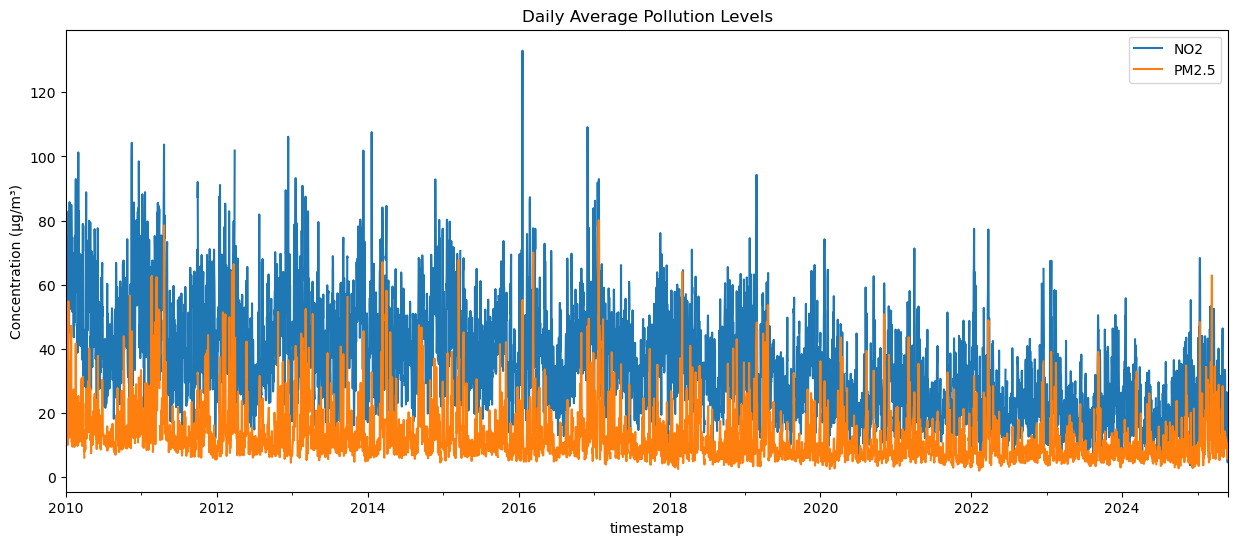

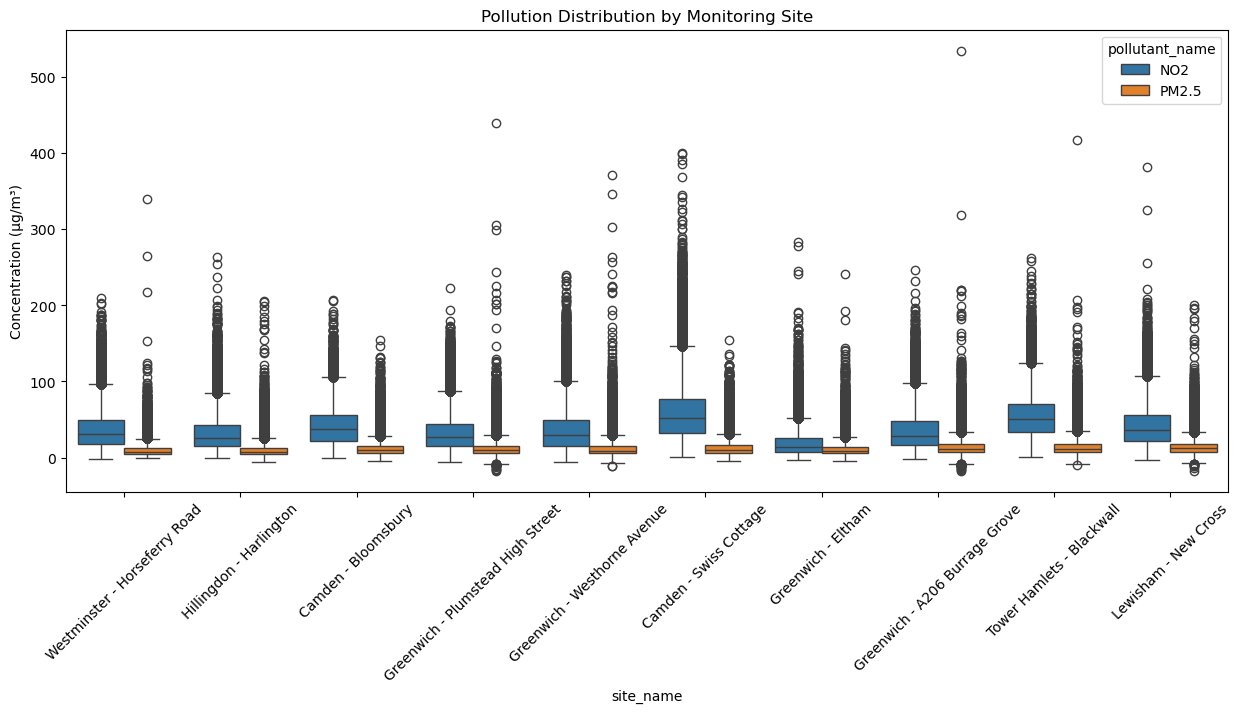


Correlation between NO2 and PM2.5:
pollutant_name       NO2     PM2.5
pollutant_name                    
NO2             1.000000  0.493587
PM2.5           0.493587  1.000000


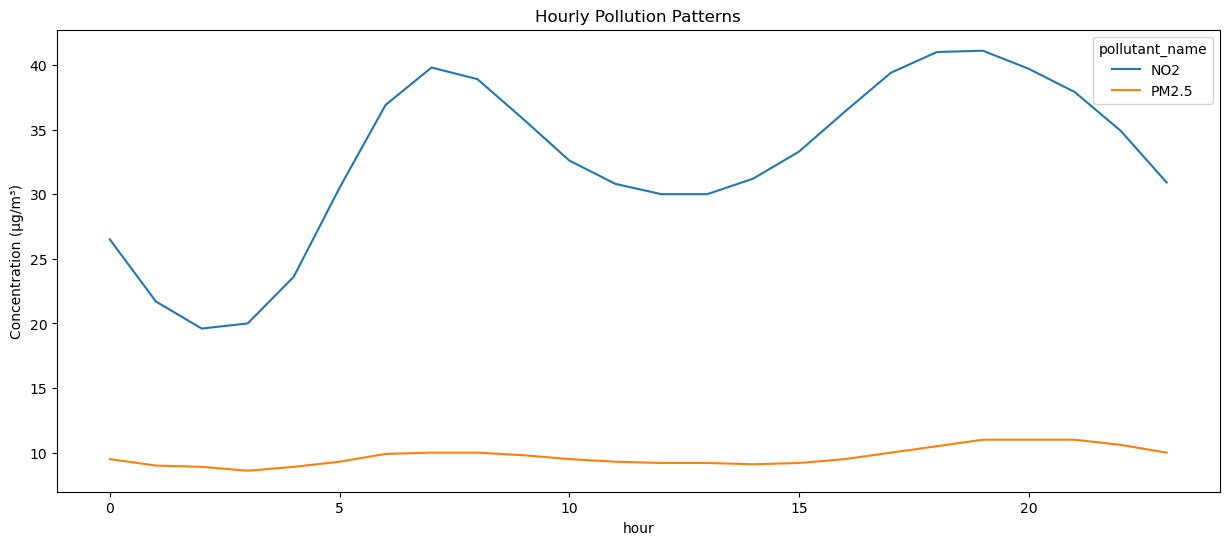

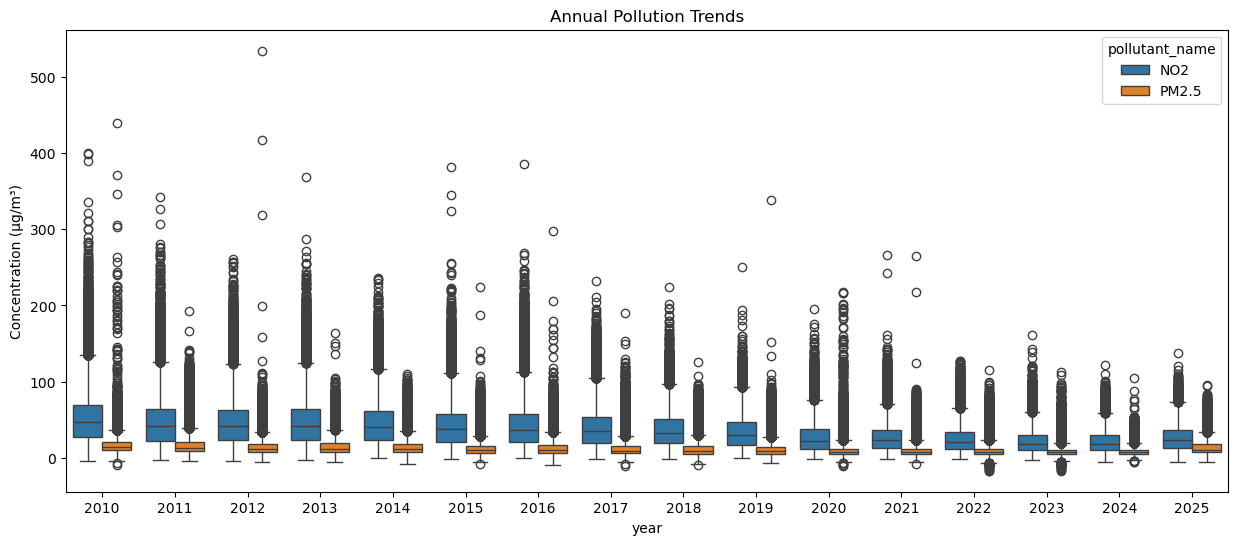

In [8]:
# Pollution Analysis
plt.figure(figsize=(15, 6))
for pollutant in ['NO2', 'PM2.5']:
    subset = df[df['pollutant_name'] == pollutant]
    subset.resample('D', on='timestamp')['value'].mean().plot(label=pollutant)
    
plt.title('Daily Average Pollution Levels')
plt.ylabel('Concentration (μg/m³)')
plt.legend()
plt.show()

# Site Comparison Analysis
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='site_name', y='value', hue='pollutant_name')
plt.title('Pollution Distribution by Monitoring Site')
plt.xticks(rotation=45)
plt.ylabel('Concentration (μg/m³)')
plt.show()

# Correlation Analysis
pivot_df = df.pivot_table(
    index=['site_code', 'timestamp'],
    columns='pollutant_name',
    values='value'
).reset_index()

print("\nCorrelation between NO2 and PM2.5:")
print(pivot_df[['NO2', 'PM2.5']].corr())

# Hourly Patterns
plt.figure(figsize=(15, 6))
sns.lineplot(data=df, x='hour', y='value', hue='pollutant_name', 
            estimator='median', errorbar=None)
plt.title('Hourly Pollution Patterns')
plt.ylabel('Concentration (μg/m³)')
plt.show()

# Annual Trends
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='year', y='value', hue='pollutant_name')
plt.title('Annual Pollution Trends')
plt.ylabel('Concentration (μg/m³)')
plt.show()